# Reading Level Difficulty Prediction with RoBERTa and LightGBM.

## This is a notebook by The Bernstein Bears, a team set up for the CommonLit competition, for more see the [leaderboard](https://www.kaggle.com/c/commonlitreadabilityprize/leaderboard).

## Authors: [Justin Chae](https://www.kaggle.com/justinchae) and [Simon Benigeri](https://www.kaggle.com/simonbenigeri)

## Project Overview and Background

### In this project, we fine-tune a pre-trained [RoBERTa model for sequence classifcation](https://huggingface.co/transformers/model_doc/roberta.html#robertaforsequenceclassification) in combination with LightGBM to predict reading level difficulty. To fine-tune RoBERTa, we use the RoBERTa regression output, i.e., the logit and train on the loss between the logit and the target value. Using the RoBERTa logit as a sole predictor, we achieve an initial public score of approximately .538. As an alternative to using the logit, we summed the last four hidden states and applied several layers of linear transformation on the document embeddings and use the resulting value to compute the loss. 

* Although the document embedding method seems to work quite well for classification tasks, in this case, it appears the logit produces the most useful feature to predict reading difficulty.

* To improve the initial score based on logit alone, we use RoBERTa as a feature extractor by using both the logit and document embeddings from the model. We initially set max sequence length to 280 based on a statistical analysis of document length and set padding to max length. Later, we expand the max length to 512 to see if a regressor can make use of more vectors for each excerpt. 

* However, it turns out that longer hidden states in the LGBMRegressor adds too much noise. After some test submissions, the long hidden states (512) reduce the RMSE by about .002 while no hidden states reduce the score by .001. Of the tested options, 280 seems to be optimal choice but other factors like LGBMRegressor tuning might be a determining factor.

### In addition to RoBERTa features (logit and embeddings), there is something to be learned from extracting statistics about the text. As a result, we leverage the [textstat](https://pypi.org/project/textstat/) library to engineer other features such as flesch-kinkaid or reading grade scores. After some experimentation, we found that evaluated metrics such as number of difficult words per document improve a regression score as opposed to logit alone. Although, it is worth noting that the output logit is a fairly strong predictor on its own. In any case, we also use a categorical reading score, i.e. '11th grade level' in the [LGBMRegressor](https://lightgbm.readthedocs.io/en/latest/pythonapi/lightgbm.LGBMRegressor.html) to boost the score further. The use of a categorical feature in LGBMRegressor seems to boost the public score to about .505.

* The result of the feature extraction methods allows us to create a feature vector that can be used in either a neural network to fine-tune RoBERTa or as an input to a machine learning regressor such as one provided by scikit-learn or in our case, the LGBMRegressor. We evaluated a variety of combinations of features such as logit with embeddings or logit with syllable count, etc, and found that a hybrid feature vector comprised of categorical reading level score, logit, difficult words ratio, extracted embedding, flesch ease score, and a few others produced optimal results.

* To get an idea of which features would be good predictors, we run a correlation function with [Pandas](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.corr.html) and choose the features that appeared to be strongly correlated, in either direction. One exception is the text standard category feature which comes from the textstat library which does not appear to be correlated but as a categorical feature in LGBMRegressor, it seems to do quite well.

### On of 12 June 2021, with LGBMRegressor and our hybrid feature vector was among the top 49% of scores with a public score of .523. After adjusting the loss function in our RoBERTa tuner (from MSE Loss to RMSE Loss), we were able to produce a logit as a reading difficulty predictor which produced a public score of .505 which was, at the time, among the top 43% of scores. 

### Lately, we started training RoBERTa for few more epochs (4 instead of 2) and have increased batch size (from 8 to 16) to smooth out the gradient. As of 18 June 2021, increasing the batch size during RoBERTa fine-tuning gives use a slight boost and produces a public score of .499 which was good enough for the top 44% of entries. After some further tuning of the LGBMRegressor, we gained a fraction of a point to move up to .497 on 19 June 2021.

### Currently, we are experimenting with text augmentation to increase the number of training samples that are available for learning a good model. However, the results are, so far, not producing better accuracy.


## Next Steps and Other Things

* The broad-based approach to fine-tune RoBERTa and tack on some encodings about text cohesion works surprisingly well to model the competition's reading difficulty measures. 
* However, this broad approach misses some finer points about unpacking the details that make a text passage difficult or not. For instance, the use of ngrams, topic modeling, and statistical measure such as TF-IDF might encode something that is more useful or perhaps just orthogonal to the RoBERTa approach. 
* Further, we really haven't pre-processed the text (outside of the RoBERTa pre-trained tokenizer), but there is likely a benefit to evaluating the corpus when considering case, punctuation, and stop words.
* Lastly, we could stand to apply some automated fine tuning for both our Transformer and Regressors and are looking to use something like Optuna to get that work done.


## Summary of Learnings

* During fine-tuning of a pre-trained RoBERTa for sequence classification, we are seeing good results with higher batch sizes and fewer epochs, i.e. batch size at between 14-16 and epochs at between 1-4. From what we are understand, both from our experimenets and from open source research, increasing the batch size seems to mitigate the effects of overfitting. 

* It is possible to fine-tune RoBERTa within the context of a regression problem. The key is to set num_labels to 1 and use the output.logit as the y_prediction; then take the loss between y_prediction and the target value. See my Kaggle utility script which presents a wrapper around the RoBERTa model from huggingface and sets up the fine-tuning at [https://www.kaggle.com/justinchae/roberta-tuner](https://www.kaggle.com/justinchae/roberta-tuner). In addition, an implementation of the model during training in another utility script that we created for this competition at [https://www.kaggle.com/justinchae/epoch-utils](https://www.kaggle.com/justinchae/epoch-utils).

* We built some additional utility scripts to handle as much outside of the main notebook as possible. In addition to the aforementioned roberta-tuner and epoch-utils, we also use [https://www.kaggle.com/justinchae/my-bert-tuner](https://www.kaggle.com/justinchae/my-bert-tuner) for orchestration and [https://www.kaggle.com/justinchae/kaggle-config](https://www.kaggle.com/justinchae/kaggle-config) to manage global project setup. Lastly, we have a utility script to manage plotting training loss and collate data for our Torch dataloader [https://www.kaggle.com/justinchae/nn-utils](https://www.kaggle.com/justinchae/nn-utils).

* While it is also possible to leverage RoBERTa hidden states as document embeddings, doing so does not seem to produce optimal results, at least the way we approached it. In what is basically a feed forward network, we take the inputs which are vectors having dimensions of batch size, sequence length, and 786 (the hidden size) and take several layers of linear transformation to produce a vector having a single value for each token in the sequence. Then finally, we take a final linear transformation to produce a single value for each excerpt and compute the loss. As compared to the "logit as a feature" method, this "doc_embedding" method produces a model with about twice the training loss and performs just as poorly on the held out data. 

* We like the LGBMRegressor to build a final model of reading difficutly becuase of its ability to handle categorical data and indifference to scaled inputs. When we use the logit as just another feature of the text in combination with features that capture elements of text cohesion and the like, we get an interesting "hybrid feature vector" that has, so far at least, produced our high score of .497. 

* For LGBMRegressor, we are still learning tons about how to use it. So far though, we like leveraging the  framework of  the LGBM dataset and LGBM train methods to learn a model as opposed to the scikit-learn method of using LGBM fit and predict which LGBM also supports. Why? The train method seems to allow us to set a varity of hyper parameters while training to an optimial number of iterations. As a result, we spend some time tinkering with depth, number of leaves, and bin size while setting early stopping conditions on iterations to prevent overfitting. 

* We initially tuned LGBMRegressor in accordance with a Kaggle blog [https://www.kaggle.com/lasmith/house-price-regression-with-lightgbm](https://www.kaggle.com/lasmith/house-price-regression-with-lightgbm). Currently we are experimenting with ways to boost accuracy during training while reducing tendency to overfit since the ultimate goal is to have a model that generalizes well over unseen data. For example, reducing max_bin size while increasing min_data_in_leaf seem to be good levers to reduce overfitting. In additionn, there seems to be a potential benefit of adjusting the feature fraction and bagging fraction from our default setting of .8 for both.

* It has been helpful to capture an internal benchmark of our models during experimentation for things like R2 Score, AUC, or RMSE against the current public score to avoid submitting too many times. For example, we save a notebook and note what our RMSE is, then we submit this same model and see what the public RMSE is. Although not entirely accurate, we can get a sense of what might work and what might not work. 

* Despite improving from .585 to .497 with the methods in this notebook, there seems to be a limit to how good we can get. As a result, we probably have to fundamentally shift how we approach this problem.

* We spent an incredible amount of time learning how to navigate some of the nuances of Kaggle, most especially, figuring out how to use our favorite libraries in Kaggle's offline "no internet" mode. After some soul searching we found that Kaggle's guidance here [https://www.kaggle.com/samuelepino/pip-installing-packages-with-no-internet](https://www.kaggle.com/samuelepino/pip-installing-packages-with-no-internet) works the best. The gist is to basically download the tar file of a given library, upload it as a dataset and then add it to your list of inputs. Then, as you can see in the top two cells of this notebook, you can just use some command line arguments to run installation scripts. 

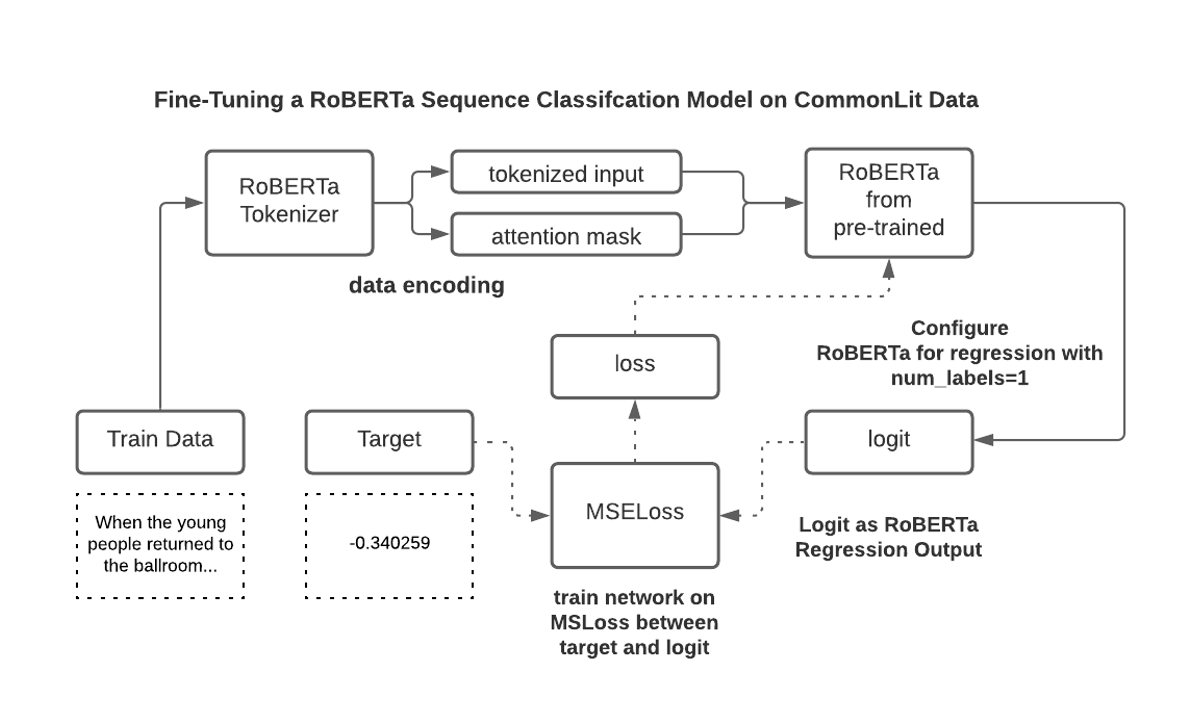

### Install some necessary dependencies for offline mode

In [ ]:
%%capture

# install necessary libraries from input
# import progressbar library for offline usage
!ls ../input/progresbar2local
!pip install progressbar2 --no-index --find-links=file:///kaggle/input/progresbar2local/progressbar2

# import text stat library for additional ml data prep
!ls ../input/textstat-local
!pip install textstat --no-index --find-links=file:///kaggle/input/textstat-local/textstat 

### Set up all notebook variables and data to control most of the experiment.

In [ ]:
%%capture

# generate more training samples with text augmentation
USE_AUGMENTED_TEXT = False
# set hyperparameters; only has an impact if fine-tuning RoBERTa
BATCH_SIZE = 14
WARM_UP = 411
LEARNING_RATE = 1.7360873300355438e-05
EPOCHS = 4
TOKENIZER_MAX_LENGTH = 280
# dropout only has an effect if using doc_embedding as a feature_type
DROPOUT = .3
# this splits the train data into a train and validation set
SPLIT_TRAIN_DATA = False
# set to true to train a new model, else use the fine-tuned version
TRAIN_FROM_SOURCE = True
# use saved features from extraction method, else extract anew
USE_PROCESSED_FEATURES = False
# choose feature type between 'logit' and 'doc_embedding'
FEATURE_TYPE = 'logit'
# do break testing, cutoff each epoch at 2 iterations to debug things
DO_BREAK_TESTING = False
# use textstats as a feature in NN training
# FIXME: due to a bug, this must be left ON for all iterations but is not actually used in the NN 
USE_TEXTSTAT = True
# specifiy loss type in NN, alteratives include "mse_loss" or "smooth_l1_loss"
LOSS_FUNCTION_TYPE = 'rmse_loss'
# specify whether to drop hidden states when running the ML regressor
DROP_HIDDEN = False
# import our custom utility scripts
import bert_utils, kaggle_config, my_bert_tuner, nn_utils, roberta_tuner
from kaggle_config import (WORKFLOW_ROOT, DATA_PATH, CACHE_PATH, FIG_PATH, 
                           MODEL_PATH, ANALYSIS_PATH, KAGGLE_INPUT)

# import the scripts from offline installer
import progressbar, textstat

import os
from os.path import basename
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
import seaborn as sns
import torch
import copy

from transformers import (RobertaForSequenceClassification, RobertaTokenizer)

# run the configuration
INPUTS, DEVICE = kaggle_config.run()
KAGGLE_TRAIN_PATH = kaggle_config.get_train_path(INPUTS)
KAGGLE_TEST_PATH = kaggle_config.get_test_path(INPUTS)

# set a seed value for consistent experimentation; optional, else leave as None
SEED_VAL = 42

if SEED_VAL:
    import random
    random.seed(SEED_VAL)
    np.random.seed(SEED_VAL)
    torch.manual_seed(SEED_VAL)
    torch.cuda.manual_seed_all(SEED_VAL)
    
# set the path to an offline tokenizer
PRETTRAINED_ROBERTA_BASE_TOKENIZER_PATH = "/kaggle/input/tokenizer-roberta"
# set the path to an offline model (pre-trained from huggingface)
PRETTRAINED_ROBERTA_BASE_MODEL_PATH = "/kaggle/input/pre-trained-roberta-base"
# set path to a fine-tuned model (this model got .53 on its own)
TUNED_ROBERTA_BASE_MODEL_PATH_LOGIT = "/kaggle/input/my-tuned-roberta-base"
# set path to a similar logit model trained on rmse (this gets closer to .51 on its own)
TUNED_ROBERTA_BASE_MODEL_PATH_LOGIT_RMSE = "/kaggle/input/crp-tuned-roberta-logit-rmse-2epoch"
# from version 54/55: logit with 4 epochs with batch size 16
TUNED_ROBERTA_BASE_MODEL_PATH_LOGIT_RMSE_4 = "/kaggle/input/crp-tuned-roberta-logit-rmse-4epoch"
# from version 84/85: logit with 4 epochs with batch size 16
TUNED_ROBERTA_BASE_MODEL_PATH_LOGIT_RMSE_TEXTAUG_2 = "/kaggle/input/crp-tuned-roberta-logit-rmse-2epoch-ta"
# from version 99: 3 epochs with text aug
TUNED_ROBERTA_BASE_MODEL_PATH_LOGIT_RMSE_TEXTAUG_3 = "/kaggle/input/crp-tuned-roberta-logit-rmse-3epoch-ta"

# a model trained to overfit on train data with logit as the feature_type, not so good
# TUNED_ROBERTA_BASE_MODEL_PATH_LOGIT_20EPOCH = "/kaggle/input/crp-tuned-roberta-logit-overfit-20"
TUNED_ROBERTA_BASE_MODEL_PATH_EMBED_9EPOCH = "/kaggle/input/crp-tuned-roberta-embed-rmse-9"

# the actual pretrained tokenizer from hugging face for use offline; a base model
PRETRAINED_ROBERTA_BASE_TOKENIZER = RobertaTokenizer.from_pretrained(PRETTRAINED_ROBERTA_BASE_TOKENIZER_PATH)
# an actual tuned model based on the logit as a predictor; wrapped inside our model class
PRETRAINED_ROBERTA_BASE_MODEL_LOGIT_REGRESSSION = roberta_tuner.RobertaLogitRegressor(pre_trained_path=PRETTRAINED_ROBERTA_BASE_MODEL_PATH
                                                                                     , device=DEVICE)

# an actual tuned model based on training the embeddings to the target value
PRETRAINED_ROBERTA_BASE_MODEL_EMBED_REGRESSION = roberta_tuner.RobertaEmbeddingRegressor(pre_trained_path=PRETTRAINED_ROBERTA_BASE_MODEL_PATH
                                                                                        , dropout_rate=DROPOUT
                                                                                        , device=DEVICE)
# this model achieves .538 on its own, trained on 1 epoch
TUNED_ROBERTA_BASE_MODEL_LOGIT_1 = roberta_tuner.RobertaLogitRegressor(pre_trained_path=TUNED_ROBERTA_BASE_MODEL_PATH_LOGIT
                                                                      , device=DEVICE)
# this is similar but trained on RSME loss, trained on 2 epoch
TUNED_ROBERTA_BASE_MODEL_LOGIT_2 = roberta_tuner.RobertaLogitRegressor(pre_trained_path=TUNED_ROBERTA_BASE_MODEL_PATH_LOGIT_RMSE
                                                                      , device=DEVICE)

# this is the best performing model with .497 after LGBM 
TUNED_ROBERTA_BASE_MODEL_LOGIT_4 = roberta_tuner.RobertaLogitRegressor(pre_trained_path=TUNED_ROBERTA_BASE_MODEL_PATH_LOGIT_RMSE_4
                                                                      , device=DEVICE)
# this made with text augmentation
TUNED_ROBERTA_BASE_MODEL_LOGIT_TA1 = roberta_tuner.RobertaLogitRegressor(pre_trained_path=TUNED_ROBERTA_BASE_MODEL_PATH_LOGIT_RMSE_TEXTAUG_2
                                                                      , device=DEVICE)
# this made with text augmentation
TUNED_ROBERTA_BASE_MODEL_LOGIT_TA2 = roberta_tuner.RobertaLogitRegressor(pre_trained_path=TUNED_ROBERTA_BASE_MODEL_PATH_LOGIT_RMSE_TEXTAUG_3
                                                                      , device=DEVICE)

# retraind with rmse loss at 9 epochs
TUNED_ROBERTA_BASE_MODEL_EMBEDDING = roberta_tuner.RobertaLogitRegressor(pre_trained_path=TUNED_ROBERTA_BASE_MODEL_PATH_EMBED_9EPOCH
                                                                        , device=DEVICE)

# set a dtype for the ID column
DTYPES = {'id': str}

# from a prior run, load a saved pickle file of hidden states and other features about the train data
PROCESSED_FROM_LOGIT_1 = os.path.join(KAGGLE_INPUT, 'crp-extracted-train-features', 'train_data_with_extracted_features.bz2')
PROCESSED_FROM_LOGIT_2 = os.path.join(KAGGLE_INPUT, 'crp-extracted-train-logit-rmse-2epoch', 'train_loader_with_extracted_features.bz2')
# from version 54/55: 4 epochs with batch size 16 -> best performer so far
PROCESSED_FROM_LOGIT_4 = os.path.join(KAGGLE_INPUT, 'crp-extracted-train-logit-rmse-4epoch', 'train_loader_with_extracted_features.bz2')
# from version 84/85: text augmentation with 2 epochs
PROCESSED_FROM_LOGIT_TA1 = os.path.join(KAGGLE_INPUT, 'crp-extracted-train-logit-rmse-2epoch-ta', 'train_loader_with_extracted_features.bz2')
# from version 99 text aug 3 epochs
PROCESSED_FROM_LOGIT_TA2 = os.path.join(KAGGLE_INPUT, 'crp-extracted-train-logit-rmse-3epoch-ta', 'train_loader_with_extracted_features.bz2')
PROCESSED_FROM_MIXED_1 = os.path.join(KAGGLE_INPUT, 'crp-extracted-train-mixed-1', 'train_loader_with_extracted_features.bz2')

### Based on all the models and data options set in the prior cell, set which of the tuned models or processed data files to use in the script. 

Example: We used the tuned model to extract logits and embeddings for the train data and the wrote that file to disk. To avoid overusing the GPU, we can just use this pre-processed file to train a regressor which does not necessarily need a GPU. 

In [ ]:
#### HERE! THIS IS THE BOTTOM LINE!!!! set which model to use and the processed data to use in this script
# use this as a switch to use in this script
TUNED_MODEL_TO_USE = TUNED_ROBERTA_BASE_MODEL_LOGIT_4
# set which processed data should be used in the script, not used if training from source
# currently skipping this one as it was created with size 512
PROCESSED_FEATURE_DATA = PROCESSED_FROM_LOGIT_4
# Optional, set a model specifically to extract word embeddings
# we tested extracting the embeddings from the model trained specifically for embeddings
EMBED_MODEL_TO_USE = None

### In computer vision, there is a concept known as image augmentation wherein we can take a very few number of images and create many times more samples. The idea is that we can take a picture, then stretch, skew, and rotate the original picture with the knowledge that all the new copies still represent the original picture. For a computer, this allows an algorithm to identify whether a slight different version of the picture is, in fact, the same thing. 

* With this project, we only get about 2,800 samples to work with. However, each sample has a target and a standard error. As a result, we know that each target could be plus or minus some amount. In addition, with RoBERTa tokenizer, we are only able to process a limited number of text from each excerpt. 

* Can we combine the concept of image augmentation with text? We can try! Below, we are testing various combinations of copies of the train data by making a copy of the first, middle, and last third of each excerpt. Then, we assign a new target to each of the copies in the amount of plus or minus half the standard error. The central idea here is to provide lots more examples from a known target baseline. The hope is to train the network on more samples and produce a better model that can generalize over new data. Unfortunately, so far, this seems to bring down the average score, so we are not currently using this feature in the current high score.

In [ ]:
# borrow the concept of image augmentation to create more training samples with text

def roberta_decoder(df, tokenizer, token_col='input_ids'):
    print("\n=== Running RoBERTa decoder\n")
    df['excerpt'] = df.apply(lambda x: tokenizer.decode(x[token_col]), axis=1) 
    return df

def augment_text(df, target_col='target', shuffle=True):
    # assume that we can create new samples based on standard error
    if target_col is not None:
        df['target_high'] = df[target_col] + (df['standard_error'] / 2)
        df['target_low'] = df[target_col] - (df['standard_error'] / 2)
    
#     # first third with high
#     aug10 = df.copy(deep=True)
#     aug10['target'] = aug10['target_high']
#     aug10['excerpt'] = aug10.apply(lambda x: x['excerpt'].split(), axis=1)
#     aug10['excerpt'] = aug10.apply(lambda x: x['excerpt'][: len(x['excerpt']) // 3], axis=1)
#     aug10['excerpt'] = aug10.apply(lambda x: " ".join(x['excerpt']), axis=1)
    
    # first half with current
#     aug11 = df.copy(deep=True)
#     if target_col is not None:
#         aug11[target_col] = aug11[target_col]
#     aug11['excerpt'] = aug11.apply(lambda x: x['excerpt'].split(), axis=1)
#     aug11['excerpt'] = aug11.apply(lambda x: x['excerpt'][: len(x['excerpt']) // 2], axis=1)
#     aug11['excerpt'] = aug11.apply(lambda x: " ".join(x['excerpt']), axis=1)
    
#     # last third with high
#     aug12 = df.copy(deep=True)
#     aug12['target'] = aug12['target_high']
#     aug12['excerpt'] = aug12.apply(lambda x: x['excerpt'].split(), axis=1)
#     aug12['excerpt'] = aug12.apply(lambda x: x['excerpt'][-len(x['excerpt']) // 3: ], axis=1)
#     aug12['excerpt'] = aug12.apply(lambda x: " ".join(x['excerpt']), axis=1)
    
#     # last third with low
#     aug13 = df.copy(deep=True)
#     aug13['target'] = aug13['target_low']
#     aug13['excerpt'] = aug13.apply(lambda x: x['excerpt'].split(), axis=1)
#     aug13['excerpt'] = aug13.apply(lambda x: x['excerpt'][-len(x['excerpt']) // 3:], axis=1)
#     aug13['excerpt'] = aug13.apply(lambda x: " ".join(x['excerpt']), axis=1)
    
    # last half with current
    aug14 = df.copy(deep=True)
    if target_col is not None:
        aug14[target_col] = aug14[target_col]
    aug14['excerpt'] = aug14.apply(lambda x: x['excerpt'].split(), axis=1)
    aug14['excerpt'] = aug14.apply(lambda x: x['excerpt'][-len(x['excerpt']) // 2:], axis=1)
    aug14['excerpt'] = aug14.apply(lambda x: " ".join(x['excerpt']), axis=1)
    
#     # middle third with high
#     aug20 = df.copy(deep=True)
#     aug20['target'] = aug20['target_high']
#     aug20['excerpt'] = aug20.apply(lambda x: x['excerpt'].split(), axis=1)
#     aug20['excerpt'] = aug20.apply(lambda x: x['excerpt'][len(x['excerpt']) // 3: len(x['excerpt']) // 3 + len(x['excerpt']) // 3], axis=1)
#     aug20['excerpt'] = aug20.apply(lambda x: " ".join(x['excerpt']), axis=1)
    
#     # middle third with low
#     aug21 = df.copy(deep=True)
#     aug21['target'] = aug21['target_low']
#     aug21['excerpt'] = aug21.apply(lambda x: x['excerpt'].split(), axis=1)
#     aug21['excerpt'] = aug21.apply(lambda x: x['excerpt'][len(x['excerpt']) // 3: len(x['excerpt']) // 3 + len(x['excerpt']) // 3], axis=1)
#     aug21['excerpt'] = aug21.apply(lambda x: " ".join(x['excerpt']), axis=1)
    
    # middle third with current
#     aug22 = df.copy(deep=True)
#     aug22['target'] = aug22['target']
#     aug22['excerpt'] = aug22.apply(lambda x: x['excerpt'].split(), axis=1)
#     aug22['excerpt'] = aug22.apply(lambda x: x['excerpt'][len(x['excerpt']) // 3: len(x['excerpt']) // 3 + len(x['excerpt']) // 3], axis=1)
#     aug22['excerpt'] = aug22.apply(lambda x: " ".join(x['excerpt']), axis=1)
    
    df = pd.concat([#aug10
#                     aug11
#                     , aug12
#                     , aug13
                    aug14
#                     , aug20
#                     , aug21
#                     , aug22
                    , df
                   ])
    if shuffle:
        df = df.sample(frac=1).reset_index(drop=True)
        
    if target_col is not None:
        df.drop(columns=['target_high', 'target_low', 'standard_error'], inplace=True)

    return df

if USE_AUGMENTED_TEXT:
#     temp = pd.read_csv(KAGGLE_TRAIN_PATH)
#     KAGGLE_TRAIN_DF = augment_text(temp)
    KAGGLE_TRAIN_DF = None
    temp = pd.read_csv(KAGGLE_TEST_PATH)
    KAGGLE_TEST_DF = augment_text(temp, target_col=None, shuffle=False)
else:
    KAGGLE_TRAIN_DF = None
    KAGGLE_TEST_DF = None

### Some idea of the models we trained for a few or many epochs and with different types of features.

Although we tried a variety of approaches, it appears that, if using this type of approach, training a BERT model in regression mode by taking the loss of the output.logit and the target value seems to move the weights into an ideal direction. Said in another way, with this method, we can interpret the output logit, for which there is just one logit per sample (as long as num_labels=1), as the reading difficulty level. The logit as a feature_type worked better as opposed to methods where we concat various text features to the emebdding space or purposefuly take the training loss to near zero (overfit).

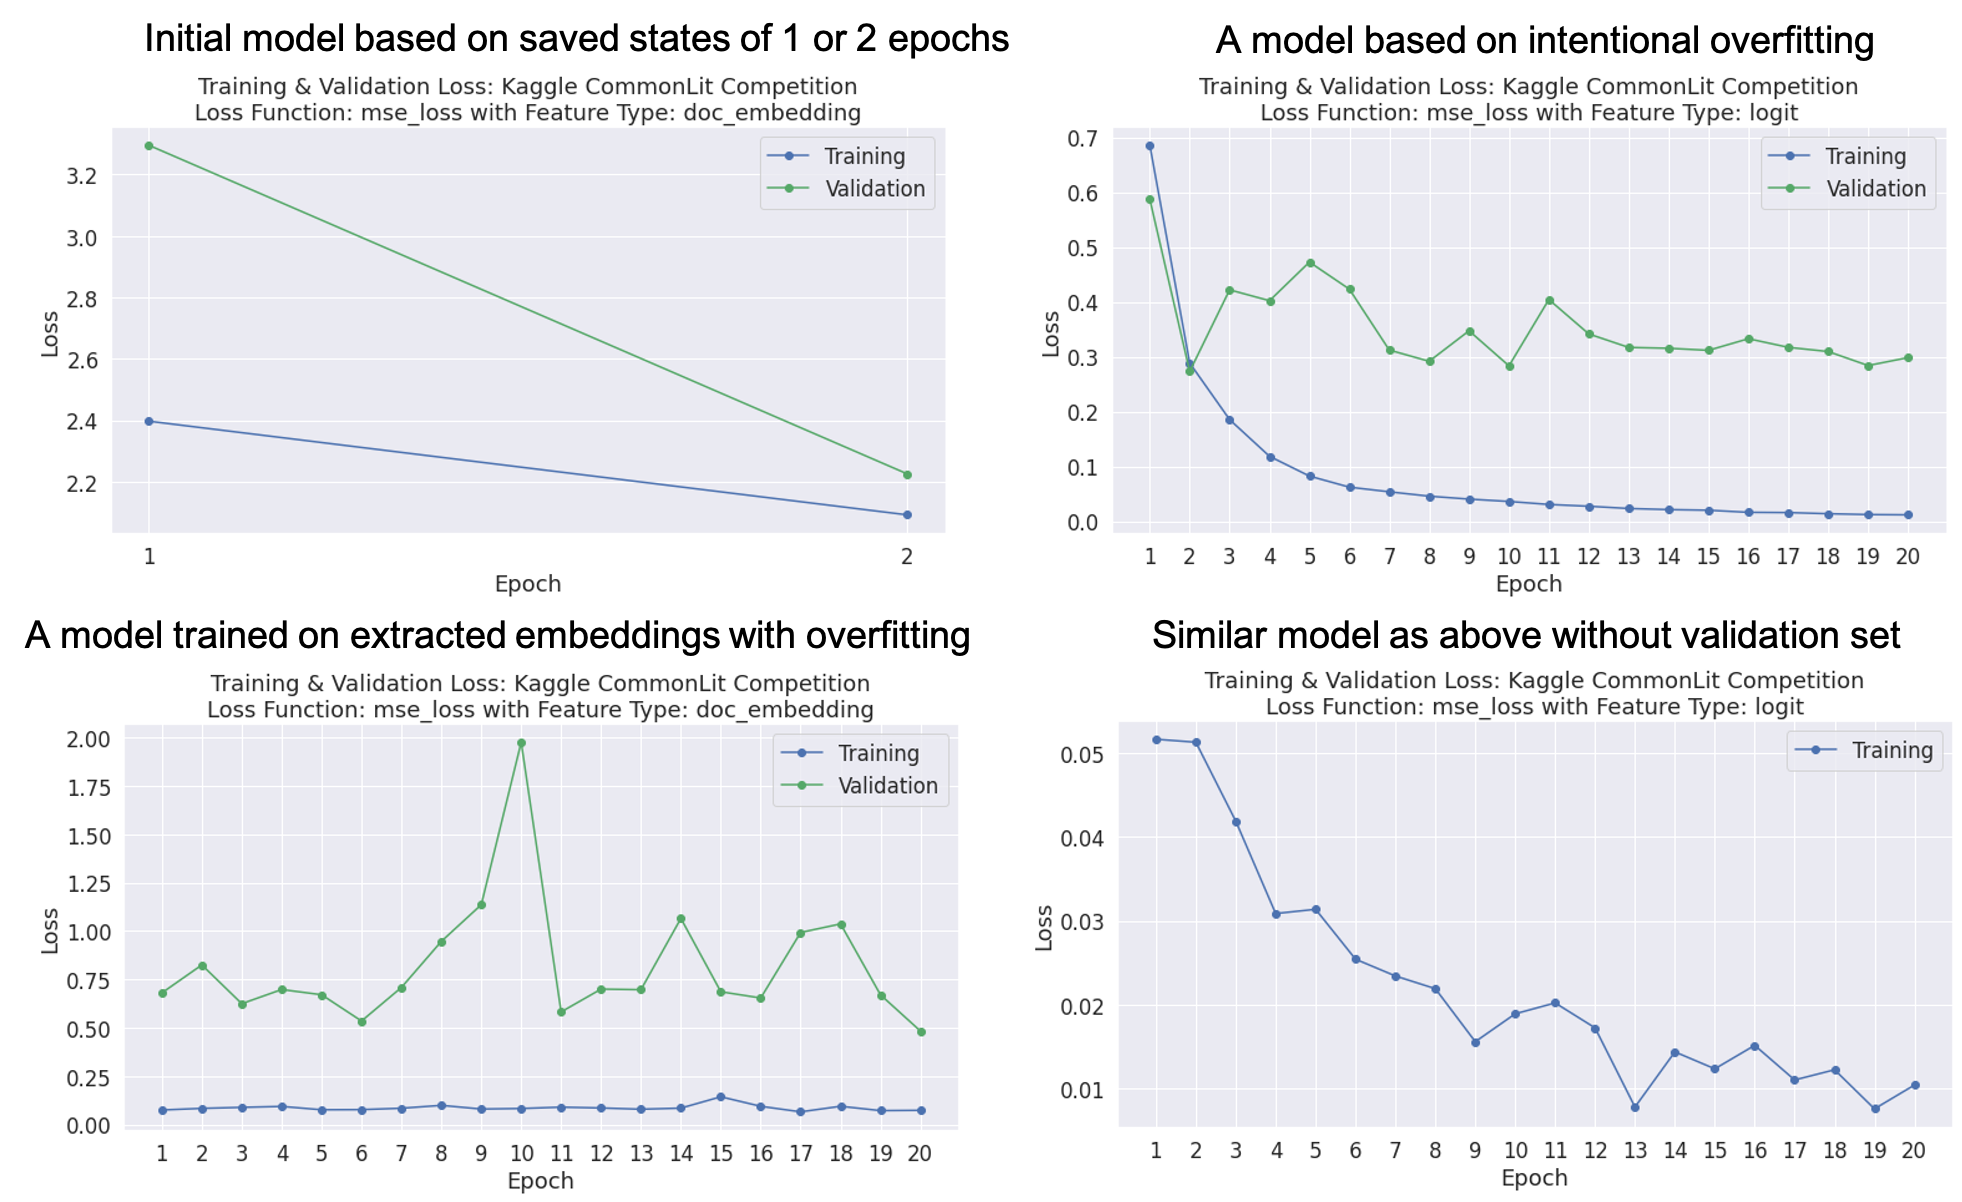

### In a previous iteration of this notebook, when we trained on the doc_embedding as a feature_type, we concatenated textstat features such as flesh-kincaid score to the embedding space before producing a final linear output for regression. However, we found that this did not yeild ideal results. Furthermore, we wanted a way to train only the embedding weights to the target value and then use the RoBERTa model in inference mode to extract features for a machine learning style regressor

In [ ]:
# call utility script to return a dictionary of dataloader objects
KAGGLE_DATA = nn_utils.get_reading_level_data(tokenizer=PRETRAINED_ROBERTA_BASE_TOKENIZER
                                             , train_path=KAGGLE_TRAIN_PATH if KAGGLE_TRAIN_DF is None else KAGGLE_TRAIN_DF
                                             , test_path=KAGGLE_TEST_PATH if KAGGLE_TEST_DF is None else KAGGLE_TEST_DF
                                             , batch_size=BATCH_SIZE
                                             , shuffle_dataloader=True
                                             , split_train_data=SPLIT_TRAIN_DATA
                                             , max_length=TOKENIZER_MAX_LENGTH 
                                              # there is currently a logic bug which requires textstat to be passed
                                              # to be fixed soon
                                             , textstat=textstat if USE_TEXTSTAT else None
                                             , dtypes=DTYPES 
                                             )

for k, v in KAGGLE_DATA.items():
    if 'num_labels' not in k:
        print(f"Loaded {k} with DataLoader Object of len({len(v)})") if v is not None else print(" ")
    else:
        print(f"There are a total of ({v}) labels in the data set.") if v is not None else print(" ")

### Here, we just return a saved model state from file instead of training it again. If needed, set the variables in the cells above and train from scratch.

In [ ]:
# this will fine-tune a roberta model from pre-trained state or return the fine-tuned state
if TRAIN_FROM_SOURCE:
    # train a new model
    model = PRETRAINED_ROBERTA_BASE_MODEL_LOGIT_REGRESSSION if FEATURE_TYPE == "logit" else PRETRAINED_ROBERTA_BASE_MODEL_EMBED_REGRESSION
    print(f"\n=== Learning a new model from source model: {model.config.architectures}.\n")
    tuned_bert_model = my_bert_tuner.run(model=model
                                         , feature_type=FEATURE_TYPE
                                         , data=KAGGLE_DATA
                                         , device=DEVICE
                                         , do_break_testing=DO_BREAK_TESTING
                                         , batch_size=BATCH_SIZE
                                         , learning_rate=LEARNING_RATE
                                         , dropout_prob=DROPOUT
                                         , warmup_steps=WARM_UP
                                         , epochs=EPOCHS
                                         , progressbar=progressbar
                                         , loss_function_type=LOSS_FUNCTION_TYPE)
    print(tuned_bert_model.config)
else:
    # use the fine-tuned model instead
    print("\n=== Reading a fine-tuned model from disk.\n")
    tuned_bert_model = TUNED_MODEL_TO_USE
    print(tuned_bert_model.config)

### For text processing, some helper functions to extract and apply various features to the data.

In [ ]:
# a helper function to create a categorical map for a given column
def make_text_standard_map(df, source_col='text_standard', cat_col='text_standard_category'):
    cat_map = df[[source_col, cat_col]].copy(deep=True)
    cat_map = cat_map.drop_duplicates()
    cat_map = cat_map.set_index(source_col)
    cat_map = cat_map.to_dict()[cat_col]
    return cat_map


def apply_text_standard_map(df, map_dict, source_col='text_standard', cat_col='text_standard_category'):
    df[cat_col] = df[source_col].map(map_dict)
    return df
    
    
def add_textstat_features(df):
    # adding the text standard seems to boost the accuracy score a bit
    df['text_standard'] = df['excerpt'].apply(lambda x: textstat.text_standard(x))
    df['text_standard_category'] = df['text_standard'].astype('category').cat.codes

    ### You can add/remove any feature below and it will be used in training and test
    df['coleman_liau_index'] = df['excerpt'].apply(lambda x: textstat.coleman_liau_index(x))
    df['flesch_reading_ease'] = df['excerpt'].apply(lambda x: textstat.flesch_reading_ease(x))
    df['smog_index'] = df['excerpt'].apply(lambda x: textstat.smog_index(x))
    df['gunning_fog'] = df['excerpt'].apply(lambda x: textstat.gunning_fog(x))
    df['flesch_kincaid_grade'] = df['excerpt'].apply(lambda x: textstat.flesch_kincaid_grade(x))
    df['automated_readability_index'] = df['excerpt'].apply(lambda x: textstat.automated_readability_index(x))
    df['dale_chall_readability_score'] = df['excerpt'].apply(lambda x: textstat.dale_chall_readability_score(x))
    df['linsear_write_formula'] = df['excerpt'].apply(lambda x: textstat.linsear_write_formula(x))
    ###
    
    return df


def process_hidden_states(df, drop_hidden_states=False):
    # for convenience, moving hidden states to the far right of the df
    if drop_hidden_states:
        df.drop(columns=['hidden_states'], inplace=True)
        return df
    
    elif "hidden_states" in df.columns:
        df['hidden_state'] = df['hidden_states']
        df.drop(columns=['hidden_states'], inplace=True)

        temp = df['hidden_state'].apply(pd.Series)
        temp = temp.rename(columns = lambda x: 'hidden_state_' + str(x))
        df = pd.concat([df, temp], axis=1)
        df.drop(columns=['hidden_state'], inplace=True)

        return df
    else:
        print("hidden_states not found in dataframe, skipping process_hidden_states")
        return df

### Here, return a pre-processed file that contains the feature space for the train data.

In [ ]:
# generating procesed features requires GPU so, we save the results of this step to disk
if USE_PROCESSED_FEATURES and os.path.isfile(PROCESSED_FEATURE_DATA):
    processed_train_data = pd.read_pickle(PROCESSED_FEATURE_DATA)
    print("\n=== Read processed data from disk\n")
    
else:
    # to generate a new processed file, do this
    processed_train_data = bert_utils.extract_features(model=tuned_bert_model
                                                      , data=KAGGLE_DATA
                                                      , device=DEVICE
                                                      , data_key="train_loader"
                                                      , progressbar=progressbar
                                                      , embedding_model=EMBED_MODEL_TO_USE
                                                      , tokenizer=PRETRAINED_ROBERTA_BASE_TOKENIZER)
        
# if not USE_AUGMENTED_TEXT:
#     commonlit_train_data = pd.read_csv(KAGGLE_TRAIN_PATH)
#     processed_train_data = pd.merge(left=processed_train_data
#                                    , right=commonlit_train_data[['id', 'excerpt']]
#                                    , how='left'
#                                    , left_on='id'
#                                    , right_on='id')

# add additional features to the data
processed_train_data = add_textstat_features(processed_train_data)

# reorder and set up data so that we don't have a column of vectors (hidden states)
processed_train_data = process_hidden_states(processed_train_data, drop_hidden_states=DROP_HIDDEN)

# save a mapping of categorical data; apply this to the test set later
text_standard_map = make_text_standard_map(processed_train_data)

# print(f"\nTrain Data | # Records: {len(processed_train_data)}\n")
print("\n=== Processed Train Data Sample\n")
print(processed_train_data.head())

### As stated before, returning the logits as a predicted reading difficulty value can produce decent results as a baseline, around .53 on the public board. Here, we just run it to make sure everything the preceded this cell is working as expected.

In [ ]:
print("\n=== Returning model predictions on logit only.\n")
logit_predictions = bert_utils.predict_from_logit(model=tuned_bert_model
                                            , data=KAGGLE_DATA
                                            , device=DEVICE
                                            , data_key="test_loader"
                                            , progressbar=progressbar)

# this can be used as a submission on its own which turns out to be pretty good
# logit_predictions.to_csv("submission.csv", index=False)

### A diagram to show a big picture of how we set up the architecture between RoBERTA and LGBMRegressor. The diagram only contains two of several textstat features but the idea is that we can concat a feature vector for each sample with as many new features as we think are necessary for good prediction. Also, we have changed the linear transformations from a default of 128 to 64.

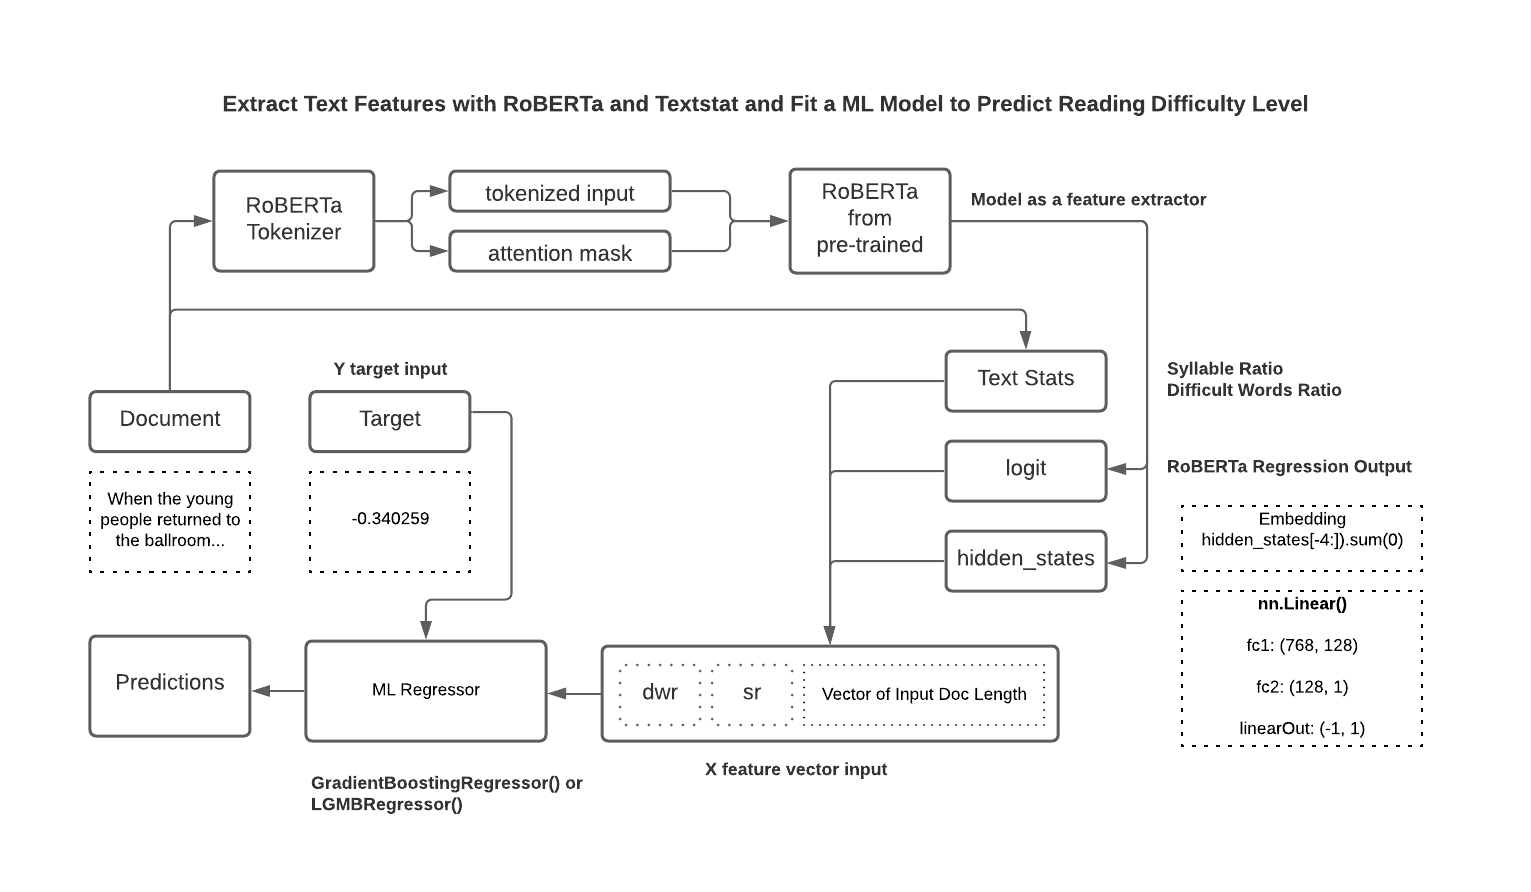

### Refine the prediction scheme with additional features in a Light GBM Regressor

Here, we just establish a baseline score based soley on the bert_logit, which we said could be used as a reading difficulty prediction. Any more work we do with a regressor should do better than this to be worth doing.

In [ ]:
import sklearn
from sklearn.ensemble import GradientBoostingRegressor
import lightgbm as lgm

from sklearn.model_selection import cross_val_score, RepeatedKFold, train_test_split
from sklearn.metrics import mean_squared_error, r2_score, mean_squared_log_error
import math

x_baseline = processed_train_data['bert_logit']
x_baseline = x_baseline.to_list()
y_target = processed_train_data["target"].to_list()

print("=" * 40)
print("Scores with Best Performing Logits from RoBERTa Regression")
print("R2 Score: ", r2_score(x_baseline, y_target))
print("RMSE Score: ", math.sqrt(mean_squared_error(y_target, x_baseline)))
print("This is only an approximation to the public score which tends to be a few points higher than our RMSE calculation.")

### Reconsider which features to include in regression

As seen below, the bert_logit, which we trained in the RoBERTa tuner is a very strong predictor while the textstats have varying strength. We think that creating a hybrid feature vector should help improve the model accuracy and generalize over unseen data. The logit, it seems, carries some valuable information about how RoBERTa has encoded the logit-target value loss and also, we get to leverage a watered down version of the embedding space by extracting the hidden states. Further, with the textstats, we encode information about what experts in the domain use to think about reading complexity.

In [ ]:
# evaluate correlation between features and targets
cols2evaluate = ['bert_logit'
               , 'difficult_words_ratio'
               , 'syllable_ratio'
               , 'smog_index'
               , 'text_standard_category'
               , 'coleman_liau_index'
               , 'flesch_reading_ease'
               , 'flesch_kincaid_grade'
               , 'gunning_fog'
               , 'automated_readability_index'
               , 'dale_chall_readability_score'
               , 'linsear_write_formula' 
               , 'target']

# https://datascience.stackexchange.com/questions/39137/how-can-i-check-the-correlation-between-features-and-target-variable
corr_tests = processed_train_data[cols2evaluate].copy(deep=True)
    
print(corr_tests[corr_tests.columns].corr()['target'][:])

### Run the LGBM Regressor Train Function

We follow a few tutorials on hyper parameter tuning for the Light GBM regressor. We chose this method over others such as SVM or RF after running some comparative tests in another notebook. Also, LGBMRegressor's ability to handle categorical features was pretty interesting. The bottom line here is that we generally want to build a strong regressor during training without overfitting.

### Some notes on LGBMRegressor Tuning

* Smaller maxbin: reduces train accuracy but has potential to increase generalization
* Bigger min_data_in_leaf: has potential to reduce overfitting

In [ ]:
# reference: https://www.kaggle.com/lasmith/house-price-regression-with-lightgbm

# organize data for easy processing in regressors
lgm_data = processed_train_data.copy(deep=True)
lgm_data = lgm_data.drop(columns=['excerpt', 'text_standard', 'id'])

# drop the columns that do not seem to add value
# after adding easy flag 
cols2remove = ['syllable_ratio'
               , 'coleman_liau_index'
               , 'flesch_kincaid_grade'
               , 'gunning_fog'
               , 'automated_readability_index'
               , 'linsear_write_formula'
              ]

lgm_data = lgm_data.drop(columns=cols2remove)

x_features = lgm_data.loc[:, lgm_data.columns != 'target']
y_target = lgm_data[['target']]

# split the train set into train and validation
X_train, X_test, y_train, y_test = train_test_split(x_features, y_target, test_size=0.2, random_state=SEED_VAL)

feature_cols = list(X_train.columns)
print("The columns used in training:\n", feature_cols[:10], "... \n")
# in the lgm.train paradigm, use the lgm.Dataset constructor
lgm_train_set = lgm.Dataset(data=X_train, categorical_feature=['text_standard_category'], label=y_train)
lgm_valid_set = lgm.Dataset(data=X_test, categorical_feature=['text_standard_category'], label=y_test)

# https://testlightgbm.readthedocs.io/en/latest/Parameters.html
# https://towardsdatascience.com/hyperparameter-tuning-to-reduce-overfitting-lightgbm-5eb81a0b464e
params = {
'boosting_type': 'gbdt',
'objective': 'regression',
'metric': 'rmse',
    # baseline at 100 for min_data_in_leaf
'min_data_in_leaf': 100,
    # baseline at .8
'feature_fraction': .8,
    # baseline at .8
'bagging_fraction': 0.8,
'bagging_freq': 10,
'max_depth': 16,
'num_leaves': 32,
'learning_rate': 0.005,
    # baseline at max_bin 256
"max_bin": 256,
"n_estimators": 10000,
}

gbm = lgm.train(params,
                lgm_train_set,
                valid_sets=[lgm_train_set, lgm_valid_set],
                early_stopping_rounds=1000,
                )

### In the preceeding output of LGBM train, we want to see the RMSE for train and valid to improve much in the same way that we would expect from a learning a model of data in a neural network. Generally, it seems that we start to get nice results in the public score when our RMSE on the given train/valid data falls below .4. However, based on results from public score submissions, we start to overfit when the RMSE on train drops towards .2, R2 score approaches .98, or when the train RMSE starts to diverg significantly from the validation RMSE. 

### For benchmarking, see how the regressor does on the entire train set

In [ ]:
# see the RMSE on all training and target data
x_features = lgm_data.loc[:, lgm_data.columns != 'target']
y_target = lgm_data[['target']]

# ensure we are using the same cols 
x_features = x_features[feature_cols]

# run predict on the trained model tree/weights
y_pred = gbm.predict(x_features)
y_target = y_target['target'].to_numpy()

print("=" * 40)
print("Scores On Train/Valid Set with LightGBM after Training")
print("R2 Score: ", r2_score(y_target, y_pred))
print("RMSE Score: ", math.sqrt(mean_squared_error(y_target, y_pred)))

### Best Scores so far for LGBM based on our measures:

#### For benchmarking, the following scores actually translate to a relatively worse score on the public board at around .51 RMSE. The caution here is that this is mostly reflecting how well you did on the train set with some of the validation set mixed in. As a result, consider this to only be good for a general measure of relative performance during hyperparameter tuning.

* R2 Score:  ~0.9002950668496916
* RSME Score:  ~0.3263062926902492

### Finally, apply a similar feature extraction method to process the test dataset. These steps should also apply to whatever held out data our model is evaluated against. 

In [ ]:
# run test data through a similar data pipeline as train data
# extract features with utility scripts
processed_test_data = bert_utils.extract_features(model=tuned_bert_model
                                                      , data=KAGGLE_DATA
                                                      , device=DEVICE
                                                      , data_key="test_loader"
                                                      , progressbar=progressbar
                                                      , embedding_model=EMBED_MODEL_TO_USE
                                                      , tokenizer=PRETRAINED_ROBERTA_BASE_TOKENIZER
                                                     )

# add additional features to the data
processed_test_data = add_textstat_features(processed_test_data)
# drop any columns from the data that we no longer want
proccessed_test_data = processed_test_data.drop(columns=cols2remove)

# reorder and set up data so that we don't have a column of vectors (hidden states)
processed_test_data = process_hidden_states(processed_test_data, drop_hidden_states=DROP_HIDDEN)

# apply the text standard score mapping dict from earlier
processed_test_data = apply_text_standard_map(processed_test_data, text_standard_map)


# get the document ids
document_ids = processed_test_data['id'].to_list()
# set up the test data
lgm_test = processed_test_data.drop(columns=['excerpt', 'text_standard', 'id'])


# ensure we are using the same colums as used in training
lgm_test = lgm_test[feature_cols]
predictions = gbm.predict(lgm_test)
submission = list(zip(document_ids, predictions))

submission = pd.DataFrame(submission, columns=['id', 'target'])
submission = submission.groupby('id').mean().reset_index()
print("=" * 40)
print("=" * 40)
print("Final ML Submission with LGBMRegressor\n")
print(submission)
submission.to_csv('submission.csv', index=False)

## Works Cited
[1] @misc{liu2019roberta,title={RoBERTa: A Robustly Optimized BERT Pretraining Approach}, 
      author={Yinhan Liu and Myle Ott and Naman Goyal and Jingfei Du and Mandar Joshi and Danqi Chen and Omer Levy and Mike Lewis
      and Luke Zettlemoyer and Veselin Stoyanov}, year={2019}, eprint={1907.11692}, archivePrefix={arXiv}, primaryClass={cs.CL}}

[2] @inproceedings{wolf-etal-2020-transformers, title = "Transformers: State-of-the-Art Natural Language Processing", author = "Thomas Wolf and Lysandre Debut and Victor Sanh and Julien Chaumond and Clement Delangue and Anthony Moi and Pierric Cistac and Tim Rault and Rémi Louf and Morgan Funtowicz and Joe Davison and Sam Shleifer and Patrick von Platen and Clara Ma and Yacine Jernite and Julien Plu and Canwen Xu and Teven Le Scao and Sylvain Gugger and Mariama Drame and Quentin Lhoest and Alexander M. Rush", booktitle = "Proceedings of the 2020 Conference on Empirical Methods in Natural Language Processing: System Demonstrations", month = oct, year = "2020", address = "Online", publisher = "Association for Computational Linguistics", url = "https://www.aclweb.org/anthology/2020.emnlp-demos.6", pages = "38--45" }

[3] @incollection{NEURIPS2019_9015, title = {PyTorch: An Imperative Style, High-Performance Deep Learning Library}, author = {Paszke, Adam and Gross, Sam and Massa, Francisco and Lerer, Adam and Bradbury, James and Chanan, Gregory and Killeen, Trevor and Lin, Zeming and Gimelshein, Natalia and Antiga, Luca and Desmaison, Alban and Kopf, Andreas and Yang, Edward and DeVito, Zachary and Raison, Martin and Tejani, Alykhan and Chilamkurthy, Sasank and Steiner, Benoit and Fang, Lu and Bai, Junjie and Chintala, Soumith}, booktitle = {Advances in Neural Information Processing Systems 32}, editor = {H. Wallach and H. Larochelle and A. Beygelzimer and F. d\textquotesingle Alch'{e}-Buc and E. Fox and R. Garnett}, pages = {8024--8035}, year = {2019}, publisher = {Curran Associates, Inc.}, url = {http://papers.neurips.cc/paper/9015-pytorch-an-imperative-style-high-performance-deep-learning-library.pdf} }

[4] Chris McCormick and Nick Ryan. (2019, July 22). BERT Fine-Tuning Tutorial with PyTorch. Retrieved from http://www.mccormickml.com

[5] @article{neeraj2020bertlayers, title = "Feature-based Approach with BERT", author = "Neeraj, Trishala", journal = "trishalaneeraj.github.io", year = "2020", url = "https://trishalaneeraj.github.io/2020-04-04/feature-based-approach-with-bert"}

[6] @article{scikit-learn,title={Scikit-learn: Machine Learning in {P}ython},author={Pedregosa, F. and Varoquaux, G. and Gramfort, A. and Michel, V.
         and Thirion, B. and Grisel, O. and Blondel, M. and Prettenhofer, P.
         and Weiss, R. and Dubourg, V. and Vanderplas, J. and Passos, A. and
         Cournapeau, D. and Brucher, M. and Perrot, M. and Duchesnay, E.},
 journal={Journal of Machine Learning Research}, volume={12},pages={2825--2830},year={2011}
}

[7] Smith, Laurence (https://www.kaggle.com/lasmith), Kaggle Notebook, retreived on 12 July 2021 from: https://www.kaggle.com/lasmith/house-price-regression-with-lightgbm.
